In [1]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

# Core imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torchvision import datasets, transforms

import timm
import os
import json
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

print("\n" + "="*70)
print("BIET - BeiT IMPLEMENTATION - COMBINED DATASET")
print("(MAIN AKSHARAS + OTTAKSHARAS)")
print("="*70)

# Kaggle API Setup
kaggle_username = input("Enter your Kaggle username: ")
kaggle_key = input("Enter your Kaggle API key: ")

os.makedirs("/root/.kaggle", exist_ok=True)
with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump({"username": kaggle_username, "key": kaggle_key}, f)

os.chmod("/root/.kaggle/kaggle.json", 600)
print("\nKaggle API configured successfully")

print("\n" + "="*70)
print("Downloading Kannada Character Datasets...")
print("="*70)

# Download main aksharas
print("\n1. Downloading main aksharas dataset...")
os.system("kaggle datasets download -d sahilkumarjamwal/handwritten-kannada-main-aksharas -p /content")

# Download ottaksharas
print("\n2. Downloading ottaksharas dataset...")
os.system("kaggle datasets download -d sahilkumarjamwal/handwritten-kannada-ottaksharas -p /content")

print("\n" + "="*70)
print("Extracting datasets...")
print("="*70)

# Unzip main aksharas
print("\nExtracting main aksharas...")
os.system("unzip -qo /content/handwritten-kannada-main-aksharas.zip -d /content/kannada_main")

# Unzip ottaksharas
print("Extracting ottaksharas...")
os.system("unzip -qo /content/handwritten-kannada-ottaksharas.zip -d /content/kannada_ottaksharas")

print("\n" + "="*70)
print("BIET - Dataset Setup Complete for BeiT Model")
print("="*70)
print("All libraries imported and datasets ready!")
print("="*70)

CUDA available: True
Device name: Tesla P100-PCIE-16GB
Using device: cuda

BIET - BeiT IMPLEMENTATION - COMBINED DATASET
(MAIN AKSHARAS + OTTAKSHARAS)


Enter your Kaggle username:  shraddhaatreya
Enter your Kaggle API key:  d7a68472a232d02050233965ab6187b4



Kaggle API configured successfully


1. Downloading main aksharas dataset...
Dataset URL: https://www.kaggle.com/datasets/sahilkumarjamwal/handwritten-kannada-main-aksharas
License(s): apache-2.0


100%|██████████| 368M/368M [00:00<00:00, 1.24GB/s]




2. Downloading ottaksharas dataset...
Dataset URL: https://www.kaggle.com/datasets/sahilkumarjamwal/handwritten-kannada-ottaksharas
License(s): apache-2.0


Extracting datasets...

Extracting main aksharas...


100%|██████████| 11.1M/11.1M [00:00<00:00, 1.05GB/s]


Extracting ottaksharas...

BIET - Dataset Setup Complete for BeiT Model
All libraries imported and datasets ready!


In [2]:
print("Locating dataset paths...\n")

# Locate main aksharas
main_path = "/content/kannada_main/handwritten-kannada-characters-main/Characters"
print(f"Main aksharas path: {main_path}")
print(f"Classes: {len(os.listdir(main_path))}")

# Locate ottaksharas
otta_path = "/content/kannada_ottaksharas/handwritten-kannada-characters-ottaksharas/Characters"
print(f"\nOttaksharas path: {otta_path}")
print(f"Classes: {len(os.listdir(otta_path))}")

# Data transforms (optimized for BeiT)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load both datasets
print("\n" + "="*70)
print("Loading datasets for BeiT model...")
print("="*70)

main_dataset = datasets.ImageFolder(root=main_path, transform=transform)
print(f"Main dataset: {len(main_dataset)} images, {len(main_dataset.classes)} classes")

otta_dataset = datasets.ImageFolder(root=otta_path, transform=transform)
print(f"Ottaksharas dataset: {len(otta_dataset)} images, {len(otta_dataset.classes)} classes")

# Adjust ottaksharas labels
num_main_classes = len(main_dataset.classes)
adjusted_otta_samples = []
for img_path, label in otta_dataset.samples:
    adjusted_label = label + num_main_classes
    adjusted_otta_samples.append((img_path, adjusted_label))

otta_dataset.samples = adjusted_otta_samples
otta_dataset.targets = [s[1] for s in adjusted_otta_samples]

# Combine datasets
combined_dataset = ConcatDataset([main_dataset, otta_dataset])
combined_classes = main_dataset.classes + [f"otta_{c}" for c in otta_dataset.classes]

print("\n" + "="*70)
print("BIET - COMBINED DATASET CREATED FOR BeiT")
print("="*70)
print(f"Total images: {len(combined_dataset):,}")
print(f"Total classes: {len(combined_classes)}")
print(f"  - Main aksharas: {len(main_dataset.classes)} classes")
print(f"  - Ottaksharas: {len(otta_dataset.classes)} classes")
print("="*70)

Locating dataset paths...

Main aksharas path: /content/kannada_main/handwritten-kannada-characters-main/Characters
Classes: 588

Ottaksharas path: /content/kannada_ottaksharas/handwritten-kannada-characters-ottaksharas/Characters
Classes: 35

Loading datasets for BeiT model...
Main dataset: 146556 images, 587 classes
Ottaksharas dataset: 8500 images, 34 classes

BIET - COMBINED DATASET CREATED FOR BeiT
Total images: 155,056
Total classes: 621
  - Main aksharas: 587 classes
  - Ottaksharas: 34 classes


In [3]:
from sklearn.model_selection import train_test_split
from collections import Counter

print("Creating stratified train-validation split for BeiT...")
print("="*70)

# Get all targets from combined dataset
main_targets = [s[1] for s in main_dataset.samples]
otta_targets = [s[1] for s in otta_dataset.samples]
all_targets = np.array(main_targets + otta_targets)

print(f"Total samples: {len(all_targets):,}")
print(f"Unique classes: {len(np.unique(all_targets))}")

# Check class distribution
class_counts = Counter(all_targets)
print(f"\nClass distribution:")
print(f"  Min samples per class: {min(class_counts.values())}")
print(f"  Max samples per class: {max(class_counts.values())}")
print(f"  Avg samples per class: {np.mean(list(class_counts.values())):.1f}")

# Perform stratified split (80/20)
print("\nPerforming stratified split...")
train_idx, val_idx = train_test_split(
    np.arange(len(all_targets)),
    test_size=0.2,
    stratify=all_targets,
    random_state=42
)

# Create subsets
train_dataset = Subset(combined_dataset, train_idx)
val_dataset = Subset(combined_dataset, val_idx)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Verify split
train_targets = [all_targets[i] for i in train_idx]
val_targets = [all_targets[i] for i in val_idx]

print("\n" + "="*70)
print("BIET - STRATIFIED SPLIT COMPLETE FOR BeiT")
print("="*70)
print(f"Training samples: {len(train_dataset):,} (80%)")
print(f"Validation samples: {len(val_dataset):,} (20%)")
print(f"Classes in training: {len(set(train_targets))}")
print(f"Classes in validation: {len(set(val_targets))}")
print("="*70)

# Store for later use
num_classes_combined = len(combined_classes)
print(f"Total classes for BeiT model: {num_classes_combined}")

Creating stratified train-validation split for BeiT...
Total samples: 155,056
Unique classes: 621

Class distribution:
  Min samples per class: 240
  Max samples per class: 250
  Avg samples per class: 249.7

Performing stratified split...

BIET - STRATIFIED SPLIT COMPLETE FOR BeiT
Training samples: 124,044 (80%)
Validation samples: 31,012 (20%)
Classes in training: 621
Classes in validation: 621
Total classes for BeiT model: 621


In [4]:
import timm
import torch

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print()

# Load BeiT (Bidirectional Encoder representation from Image Transformers)
# Options: 'beit_base_patch16_224', 'beit_large_patch16_224'
model_name = 'beit_base_patch16_224'

print("Loading BeiT model from timm...")
print("Note: BeiT uses self-supervised pre-training with masked image modeling")

# Create model with combined classes
model = timm.create_model(model_name, pretrained=True, num_classes=num_classes_combined)
model = model.to(device)

print("\n" + "="*70)
print("BIET - MODEL CONFIGURATION (BeiT)")
print("="*70)
print(f"Model: {model_name}")
print(f"Pre-training: Self-supervised (Masked Image Modeling)")
print(f"Number of classes: {num_classes_combined}")
print(f"  - Main aksharas: 587 classes")
print(f"  - Ottaksharas: 34 classes")
print(f"Device: {device}")
print("-"*70)

# Check parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print("="*70)
print("BeiT model loaded successfully for BIET!")
print("="*70)

Using device: cuda
GPU: Tesla P100-PCIE-16GB

Loading BeiT model from timm...
Note: BeiT uses self-supervised pre-training with masked image modeling


model.safetensors:   0%|          | 0.00/350M [00:00<?, ?B/s]


BIET - MODEL CONFIGURATION (BeiT)
Model: beit_base_patch16_224
Pre-training: Self-supervised (Masked Image Modeling)
Number of classes: 621
  - Main aksharas: 587 classes
  - Ottaksharas: 34 classes
Device: cuda
----------------------------------------------------------------------
Total parameters: 86,239,533
Trainable parameters: 86,239,533
BeiT model loaded successfully for BIET!


In [7]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

print("Setting up training configuration for BeiT...")
print("="*70)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer - Using AdamW with adjusted parameters for BeiT
# BeiT typically benefits from slightly lower learning rate than DeiT
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.05)

# Learning rate scheduler (Cosine Annealing)
num_epochs = 5  # Start with 7 epochs as with DeiT
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

print("Training Configuration for BeiT:")
print("-"*70)
print(f"Loss function: CrossEntropyLoss")
print(f"Optimizer: AdamW")
print(f"  - Learning rate: 5e-5 (adjusted for BeiT)")
print(f"  - Weight decay: 0.05")
print(f"Scheduler: CosineAnnealingLR")
print(f"  - T_max: {num_epochs} epochs")
print(f"  - Min LR: 1e-6")
print(f"Number of epochs: {num_epochs}")
print("="*70)
print("BeiT training setup complete for BIET!")

print("="*70)

Setting up training configuration for BeiT...
Training Configuration for BeiT:
----------------------------------------------------------------------
Loss function: CrossEntropyLoss
Optimizer: AdamW
  - Learning rate: 5e-5 (adjusted for BeiT)
  - Weight decay: 0.05
Scheduler: CosineAnnealingLR
  - T_max: 5 epochs
  - Min LR: 1e-6
Number of epochs: 5
BeiT training setup complete for BIET!


In [8]:
import time
from tqdm import tqdm

# Training history
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print("="*70)
print("BIET - STARTING BeiT MODEL TRAINING")
print("="*70)

# Training loop
for epoch in range(num_epochs):
    epoch_start = time.time()
    
    # ========== TRAINING PHASE ==========
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        train_bar.set_postfix({
            'loss': f'{running_loss/len(train_bar):.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # ========== VALIDATION PHASE ==========
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
            
            val_bar.set_postfix({
                'loss': f'{val_running_loss/len(val_bar):.4f}',
                'acc': f'{100.*val_correct/val_total:.2f}%'
            })
    
    val_loss = val_running_loss / len(val_loader)
    val_acc = 100. * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Update learning rate
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    
    # Epoch summary
    epoch_time = time.time() - epoch_start
    print(f"\n{'='*70}")
    print(f"Epoch {epoch+1}/{num_epochs} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"  Learning Rate: {current_lr:.6f}")
    print(f"  Time: {epoch_time:.2f}s")
    print(f"{'='*70}\n")

print("="*70)
print("BIET - BeiT MODEL TRAINING COMPLETE!")
print("="*70)
print(f"Best Validation Accuracy: {max(val_accuracies):.2f}%")
print(f"Final Training Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")
print("="*70)

BIET - STARTING BeiT MODEL TRAINING


Epoch 1/5 [Val]: 100%|██████████| 970/970 [03:12<00:00,  5.03it/s, loss=0.1960, acc=97.10%]



Epoch 1/5 Summary:
  Train Loss: 2.9124 | Train Acc: 49.09%
  Val Loss: 0.1960 | Val Acc: 97.10%
  Learning Rate: 0.000045
  Time: 2619.30s



Epoch 2/5 [Val]: 100%|██████████| 970/970 [03:13<00:00,  5.02it/s, loss=0.0720, acc=97.94%]



Epoch 2/5 Summary:
  Train Loss: 0.0989 | Train Acc: 97.95%
  Val Loss: 0.0720 | Val Acc: 97.94%
  Learning Rate: 0.000033
  Time: 2628.30s



Epoch 3/5 [Val]: 100%|██████████| 970/970 [03:13<00:00,  5.02it/s, loss=0.0288, acc=99.08%]



Epoch 3/5 Summary:
  Train Loss: 0.0355 | Train Acc: 98.98%
  Val Loss: 0.0288 | Val Acc: 99.08%
  Learning Rate: 0.000018
  Time: 2632.86s



Epoch 4/5 [Val]: 100%|██████████| 970/970 [03:13<00:00,  5.02it/s, loss=0.0140, acc=99.55%]



Epoch 4/5 Summary:
  Train Loss: 0.0127 | Train Acc: 99.62%
  Val Loss: 0.0140 | Val Acc: 99.55%
  Learning Rate: 0.000006
  Time: 2633.34s



Epoch 5/5 [Val]: 100%|██████████| 970/970 [03:13<00:00,  5.02it/s, loss=0.0051, acc=99.84%]


Epoch 5/5 Summary:
  Train Loss: 0.0035 | Train Acc: 99.93%
  Val Loss: 0.0051 | Val Acc: 99.84%
  Learning Rate: 0.000001
  Time: 2633.07s

BIET - BeiT MODEL TRAINING COMPLETE!
Best Validation Accuracy: 99.84%
Final Training Accuracy: 99.93%
Final Validation Accuracy: 99.84%


Creating training visualizations for BeiT...


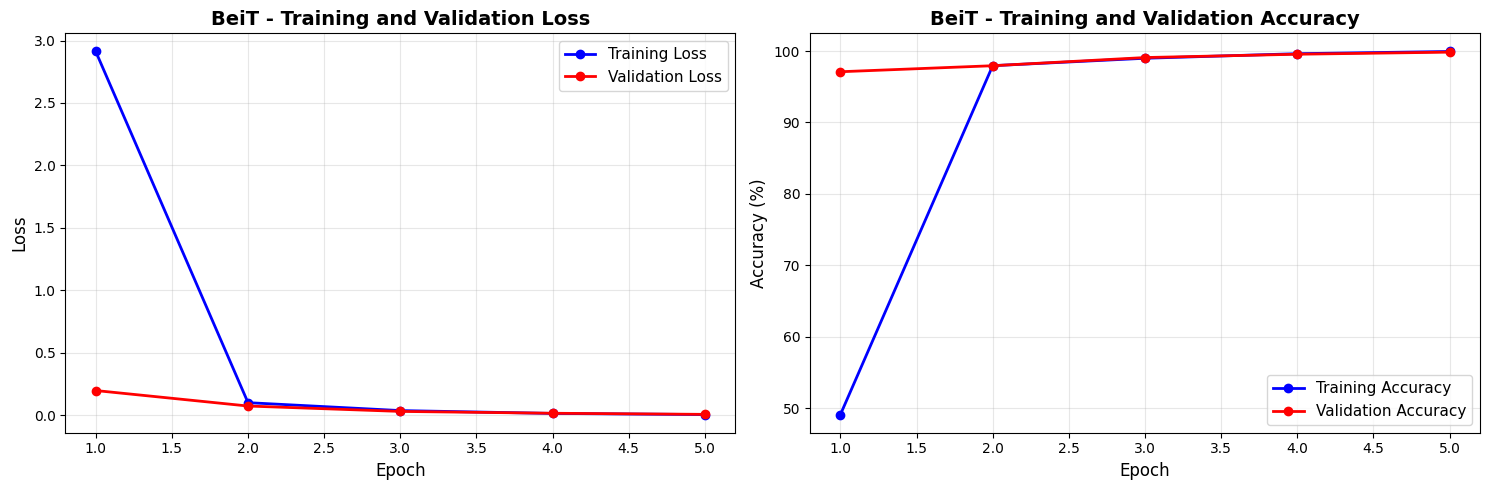


BIET - BeiT TRAINING METRICS SUMMARY
Epoch-by-Epoch Results:
----------------------------------------------------------------------
Epoch 1: Train Acc: 49.09% | Val Acc: 97.10% | Train Loss: 2.9124 | Val Loss: 0.1960
Epoch 2: Train Acc: 97.95% | Val Acc: 97.94% | Train Loss: 0.0989 | Val Loss: 0.0720
Epoch 3: Train Acc: 98.98% | Val Acc: 99.08% | Train Loss: 0.0355 | Val Loss: 0.0288
Epoch 4: Train Acc: 99.62% | Val Acc: 99.55% | Train Loss: 0.0127 | Val Loss: 0.0140
Epoch 5: Train Acc: 99.93% | Val Acc: 99.84% | Train Loss: 0.0035 | Val Loss: 0.0051
Best Validation Accuracy: 99.84% (Epoch 5)
Final Gap (Train - Val): 0.09%


In [11]:
import matplotlib.pyplot as plt

print("Creating training visualizations for BeiT...")
print("="*70)

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Loss curves
axes[0].plot(range(1, num_epochs+1), train_losses, 'b-o', label='Training Loss', linewidth=2)
axes[0].plot(range(1, num_epochs+1), val_losses, 'r-o', label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('BeiT - Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy curves
axes[1].plot(range(1, num_epochs+1), train_accuracies, 'b-o', label='Training Accuracy', linewidth=2)
axes[1].plot(range(1, num_epochs+1), val_accuracies, 'r-o', label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('BeiT - Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/beit_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("BIET - BeiT TRAINING METRICS SUMMARY")
print("="*70)
print(f"Epoch-by-Epoch Results:")
print("-"*70)
for i in range(num_epochs):
    print(f"Epoch {i+1}: Train Acc: {train_accuracies[i]:.2f}% | Val Acc: {val_accuracies[i]:.2f}% | "
          f"Train Loss: {train_losses[i]:.4f} | Val Loss: {val_losses[i]:.4f}")
print("="*70)
print(f"Best Validation Accuracy: {max(val_accuracies):.2f}% (Epoch {val_accuracies.index(max(val_accuracies))+1})")
print(f"Final Gap (Train - Val): {train_accuracies[-1] - val_accuracies[-1]:.2f}%")
print("="*70)

Testing BeiT model on sample images from dataset...


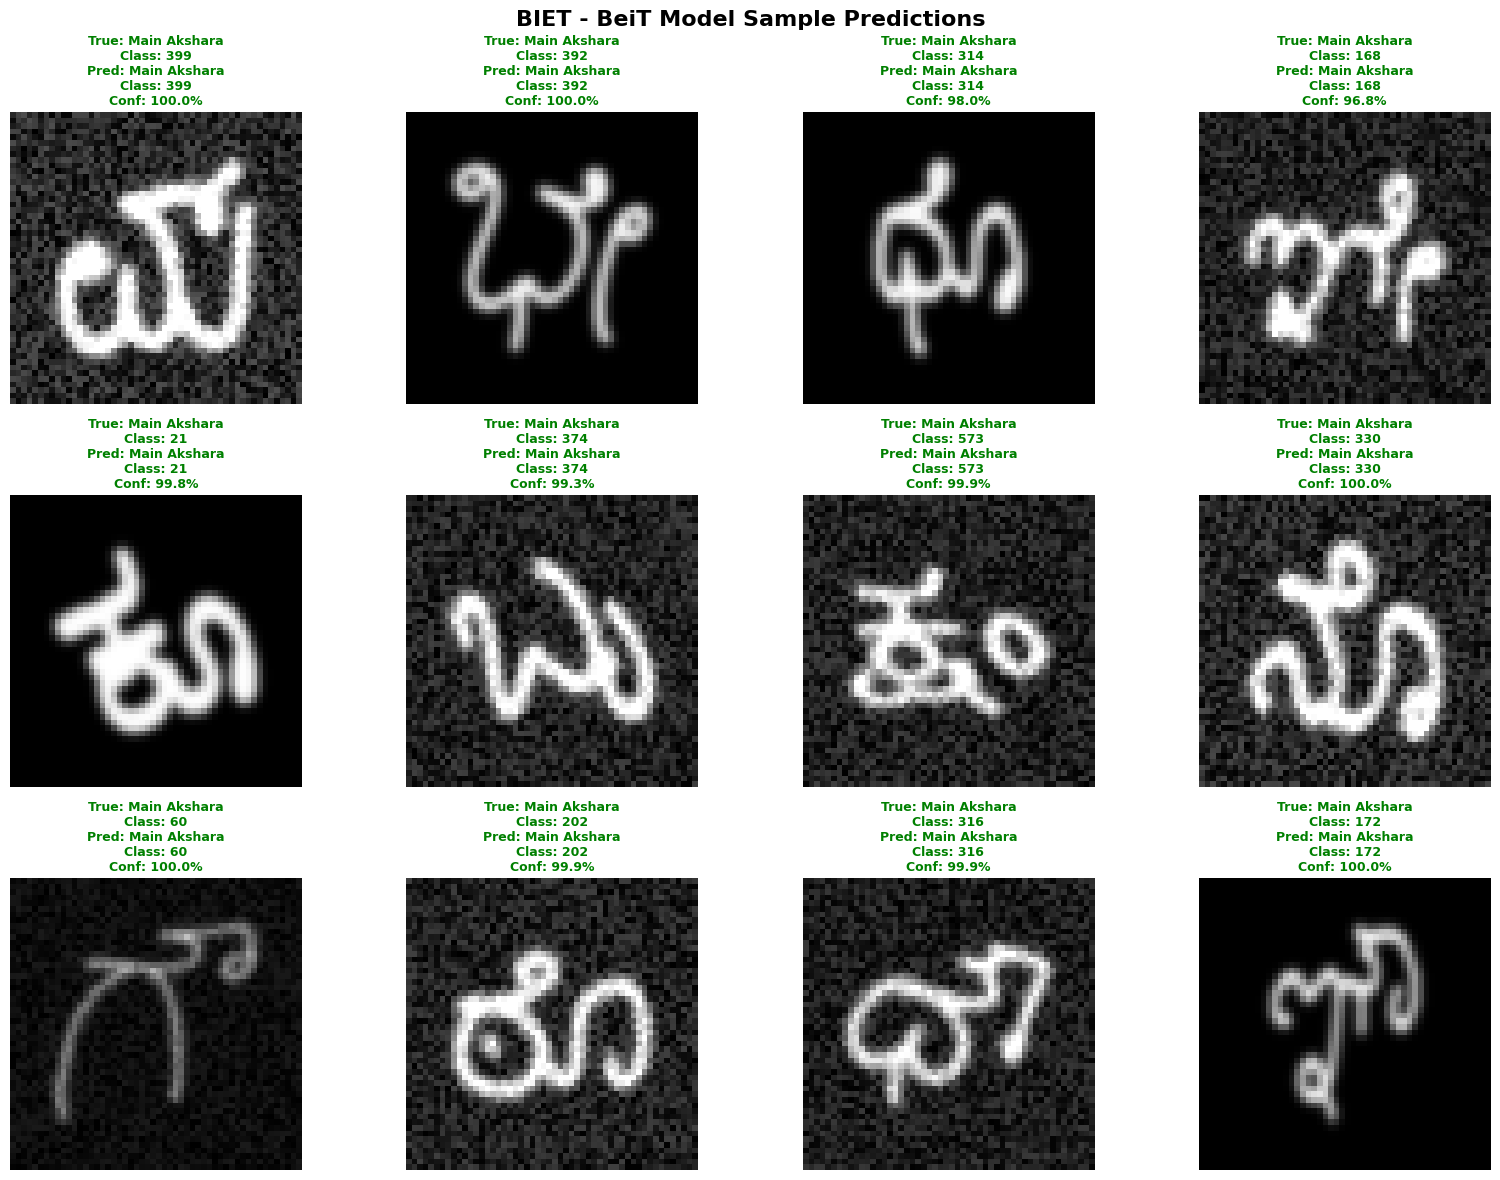


BIET - BeiT SAMPLE CLASSIFICATION RESULTS
Samples tested: 12
Correct predictions: 12/12
Sample accuracy: 100.00%

Detailed Breakdown:
  Main Aksharas tested: 12
  Ottaksharas tested: 0


In [12]:
import random
from PIL import Image
import matplotlib.pyplot as plt

print("Testing BeiT model on sample images from dataset...")
print("="*70)

# Function to determine if class is ottakshara or main
def classify_type(class_idx, num_main_classes):
    if class_idx < num_main_classes:
        return "Main Akshara", class_idx
    else:
        return "Ottakshara", class_idx - num_main_classes

# Get random samples from validation set
num_samples = 12
sample_indices = random.sample(range(len(val_dataset)), num_samples)

# Create figure
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

model.eval()
correct_predictions = 0

with torch.no_grad():
    for idx, sample_idx in enumerate(sample_indices):
        # Get image and true label
        image, true_label = val_dataset[sample_idx]
        
        # Get original image path for display
        original_idx = val_idx[sample_idx]
        if original_idx < len(main_dataset):
            img_path, _ = main_dataset.samples[original_idx]
        else:
            otta_idx = original_idx - len(main_dataset)
            img_path, _ = otta_dataset.samples[otta_idx]
        
        # Load original image for display
        original_img = Image.open(img_path).convert('RGB')
        
        # Predict
        image_input = image.unsqueeze(0).to(device)
        output = model(image_input)
        _, predicted = output.max(1)
        predicted_label = predicted.item()
        
        # Get confidence
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        confidence = probabilities[predicted_label].item() * 100
        
        # Classify type
        true_type, true_class = classify_type(true_label, num_main_classes)
        pred_type, pred_class = classify_type(predicted_label, num_main_classes)
        
        # Check if correct
        is_correct = (predicted_label == true_label)
        if is_correct:
            correct_predictions += 1
        
        # Display
        axes[idx].imshow(original_img, cmap='gray')
        axes[idx].axis('off')
        
        # Create title with type classification
        title_color = 'green' if is_correct else 'red'
        title = f"True: {true_type}\nClass: {combined_classes[true_label][:15]}\n"
        title += f"Pred: {pred_type}\nClass: {combined_classes[predicted_label][:15]}\n"
        title += f"Conf: {confidence:.1f}%"
        
        axes[idx].set_title(title, fontsize=9, color=title_color, fontweight='bold')

plt.suptitle('BIET - BeiT Model Sample Predictions', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/beit_sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("BIET - BeiT SAMPLE CLASSIFICATION RESULTS")
print("="*70)
print(f"Samples tested: {num_samples}")
print(f"Correct predictions: {correct_predictions}/{num_samples}")
print(f"Sample accuracy: {100*correct_predictions/num_samples:.2f}%")
print("="*70)

# Additional breakdown
print("\nDetailed Breakdown:")
main_samples = sum(1 for idx in sample_indices if val_dataset[idx][1] < num_main_classes)
otta_samples = num_samples - main_samples
print(f"  Main Aksharas tested: {main_samples}")
print(f"  Ottaksharas tested: {otta_samples}")
print("="*70)

Calculating metrics and creating visualizations for BeiT...
Computing validation metrics...


Processing: 100%|██████████| 970/970 [03:12<00:00,  5.05it/s]


Metrics calculated: Acc=99.84%, P=0.9985, R=0.9984, F1=0.9984

Creating 12-plot visualization...


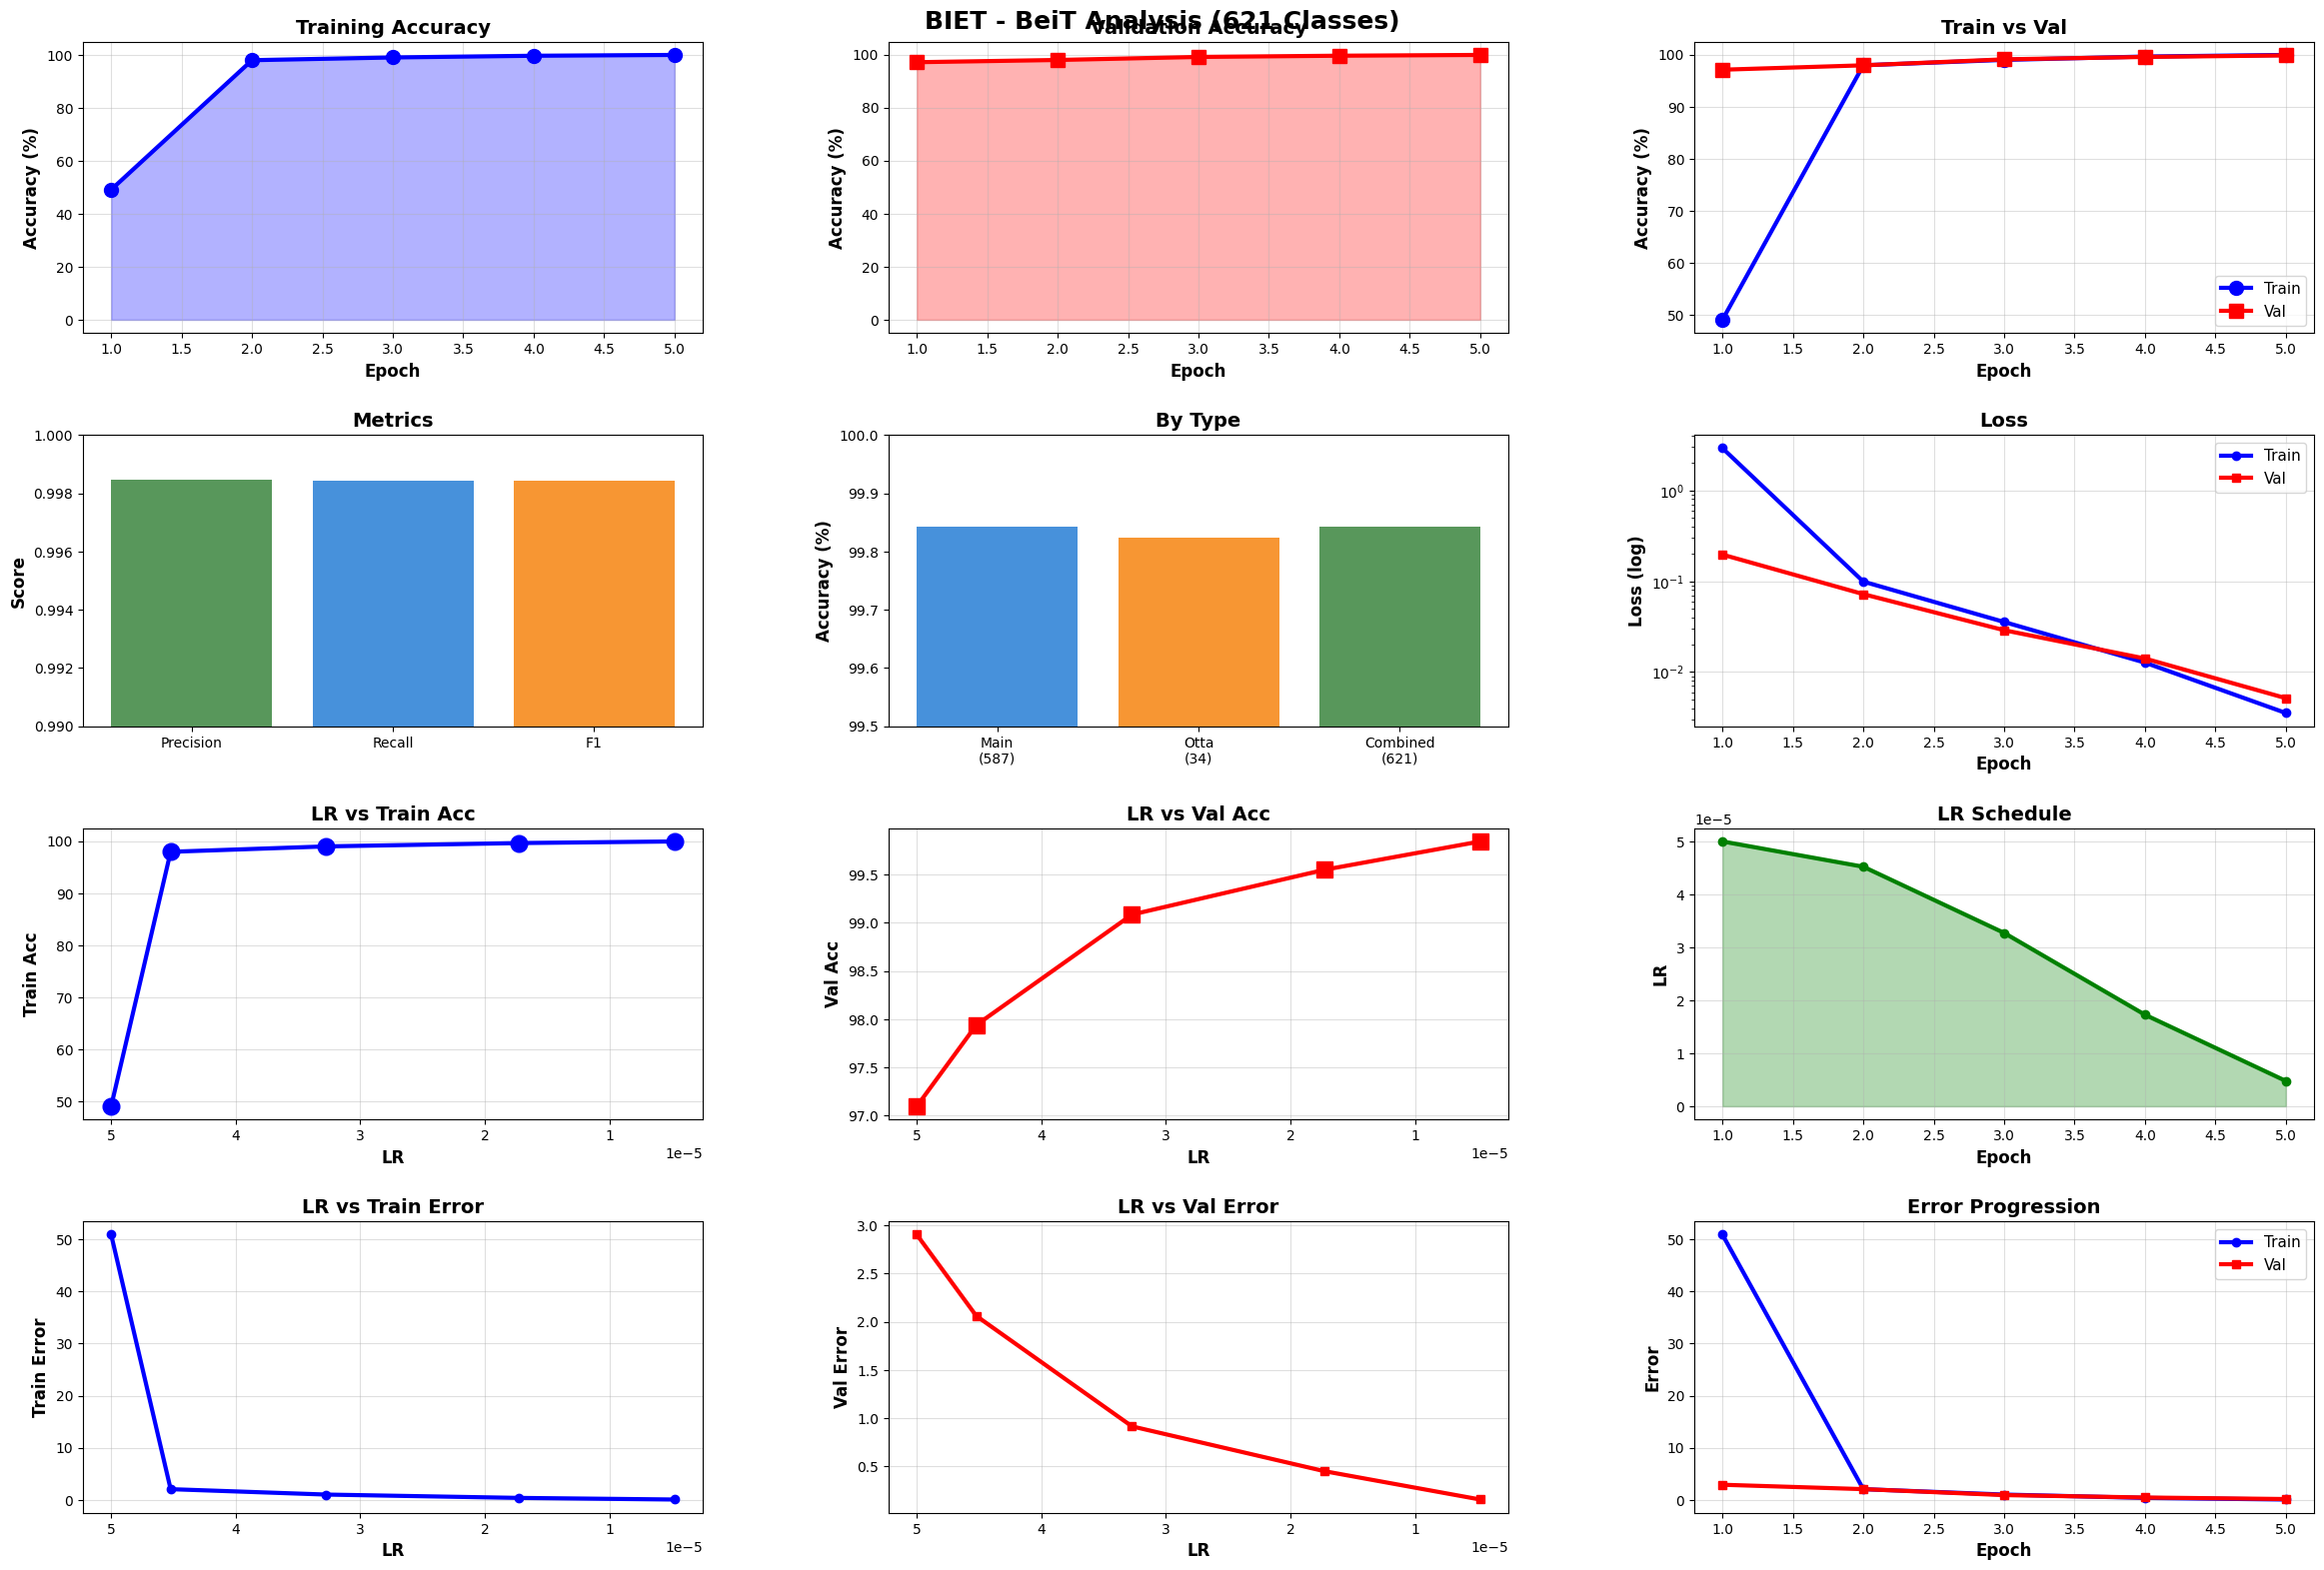

Saved: /content/beit_performance_analysis.png


In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

print("Calculating metrics and creating visualizations for BeiT...")
print("="*70)

# Calculate metrics first
model.eval()
all_preds = []
all_labels = []

print("Computing validation metrics...")
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Processing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate metrics
accuracy = 100. * np.mean(all_preds == all_labels)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

main_mask = all_labels < num_main_classes
otta_mask = all_labels >= num_main_classes
main_acc = 100. * np.mean(all_preds[main_mask] == all_labels[main_mask])
otta_acc = 100. * np.mean(all_preds[otta_mask] == all_labels[otta_mask])

beit_metrics = {
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'main_acc': main_acc,
    'otta_acc': otta_acc
}

train_accs = train_accuracies
val_accs = val_accuracies

print(f"Metrics calculated: Acc={accuracy:.2f}%, P={precision:.4f}, R={recall:.4f}, F1={f1:.4f}")

# Now create visualization
print("\nCreating 12-plot visualization...")
fig = plt.figure(figsize=(24, 16))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3, top=0.96, bottom=0.04, left=0.05, right=0.98)

lr_history = [0.00005 * 0.5 * (1 + np.cos(np.pi * epoch / num_epochs)) for epoch in range(num_epochs)]
epochs = range(1, num_epochs + 1)
train_error = [100 - acc for acc in train_accs]
val_error = [100 - acc for acc in val_accs]

# ROW 1: ACCURACY
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(epochs, train_accs, 'b-o', linewidth=3, markersize=10)
ax1.fill_between(epochs, train_accs, alpha=0.3, color='blue')
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Training Accuracy', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.4)

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(epochs, val_accs, 'r-s', linewidth=3, markersize=10)
ax2.fill_between(epochs, val_accs, alpha=0.3, color='red')
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('Validation Accuracy', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.4)

ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(epochs, train_accs, 'b-o', linewidth=3, markersize=10, label='Train')
ax3.plot(epochs, val_accs, 'r-s', linewidth=3, markersize=10, label='Val')
ax3.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax3.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax3.set_title('Train vs Val', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.4)

# ROW 2: METRICS
ax4 = fig.add_subplot(gs[1, 0])
bars = ax4.bar(['Precision', 'Recall', 'F1'], 
               [beit_metrics['precision'], beit_metrics['recall'], beit_metrics['f1_score']],
               color=['#2E7D32', '#1976D2', '#F57C00'], alpha=0.8)
ax4.set_ylabel('Score', fontsize=12, fontweight='bold')
ax4.set_title('Metrics', fontsize=14, fontweight='bold')
ax4.set_ylim([0.99, 1.0])

ax5 = fig.add_subplot(gs[1, 1])
bars = ax5.bar(['Main\n(587)', 'Otta\n(34)', 'Combined\n(621)'],
               [main_acc, otta_acc, accuracy],
               color=['#1976D2', '#F57C00', '#2E7D32'], alpha=0.8)
ax5.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax5.set_title('By Type', fontsize=14, fontweight='bold')
ax5.set_ylim([99.5, 100])

ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(epochs, train_losses, 'b-o', linewidth=3, label='Train')
ax6.plot(epochs, val_losses, 'r-s', linewidth=3, label='Val')
ax6.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax6.set_ylabel('Loss (log)', fontsize=12, fontweight='bold')
ax6.set_title('Loss', fontsize=14, fontweight='bold')
ax6.legend(fontsize=11)
ax6.set_yscale('log')
ax6.grid(True, alpha=0.4)

# ROW 3: LR
ax7 = fig.add_subplot(gs[2, 0])
ax7.plot(lr_history, train_accs, 'b-o', linewidth=3, markersize=12)
ax7.set_xlabel('LR', fontsize=12, fontweight='bold')
ax7.set_ylabel('Train Acc', fontsize=12, fontweight='bold')
ax7.set_title('LR vs Train Acc', fontsize=14, fontweight='bold')
ax7.invert_xaxis()
ax7.grid(True, alpha=0.4)

ax8 = fig.add_subplot(gs[2, 1])
ax8.plot(lr_history, val_accs, 'r-s', linewidth=3, markersize=12)
ax8.set_xlabel('LR', fontsize=12, fontweight='bold')
ax8.set_ylabel('Val Acc', fontsize=12, fontweight='bold')
ax8.set_title('LR vs Val Acc', fontsize=14, fontweight='bold')
ax8.invert_xaxis()
ax8.grid(True, alpha=0.4)

ax9 = fig.add_subplot(gs[2, 2])
ax9.plot(epochs, lr_history, 'g-o', linewidth=3)
ax9.fill_between(epochs, lr_history, alpha=0.3, color='green')
ax9.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax9.set_ylabel('LR', fontsize=12, fontweight='bold')
ax9.set_title('LR Schedule', fontsize=14, fontweight='bold')
ax9.grid(True, alpha=0.4)

# ROW 4: ERROR
ax10 = fig.add_subplot(gs[3, 0])
ax10.plot(lr_history, train_error, 'b-o', linewidth=3)
ax10.set_xlabel('LR', fontsize=12, fontweight='bold')
ax10.set_ylabel('Train Error', fontsize=12, fontweight='bold')
ax10.set_title('LR vs Train Error', fontsize=14, fontweight='bold')
ax10.invert_xaxis()
ax10.grid(True, alpha=0.4)

ax11 = fig.add_subplot(gs[3, 1])
ax11.plot(lr_history, val_error, 'r-s', linewidth=3)
ax11.set_xlabel('LR', fontsize=12, fontweight='bold')
ax11.set_ylabel('Val Error', fontsize=12, fontweight='bold')
ax11.set_title('LR vs Val Error', fontsize=14, fontweight='bold')
ax11.invert_xaxis()
ax11.grid(True, alpha=0.4)

ax12 = fig.add_subplot(gs[3, 2])
ax12.plot(epochs, train_error, 'b-o', linewidth=3, label='Train')
ax12.plot(epochs, val_error, 'r-s', linewidth=3, label='Val')
ax12.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax12.set_ylabel('Error', fontsize=12, fontweight='bold')
ax12.set_title('Error Progression', fontsize=14, fontweight='bold')
ax12.legend(fontsize=11)
ax12.grid(True, alpha=0.4)

fig.suptitle('BIET - BeiT Analysis (621 Classes)', fontsize=18, fontweight='bold')
plt.savefig('/content/beit_performance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: /content/beit_performance_analysis.png")
print("="*70)

Creating confusion matrix analysis for BeiT...

Classes with most misclassifications:
Class ID   Type            Total Errors   
----------------------------------------
522        Main            6              
109        Main            4              
241        Main            4              
192        Main            3              
382        Main            3              
297        Main            3              
520        Main            3              
561        Main            2              
126        Main            2              
525        Main            2              


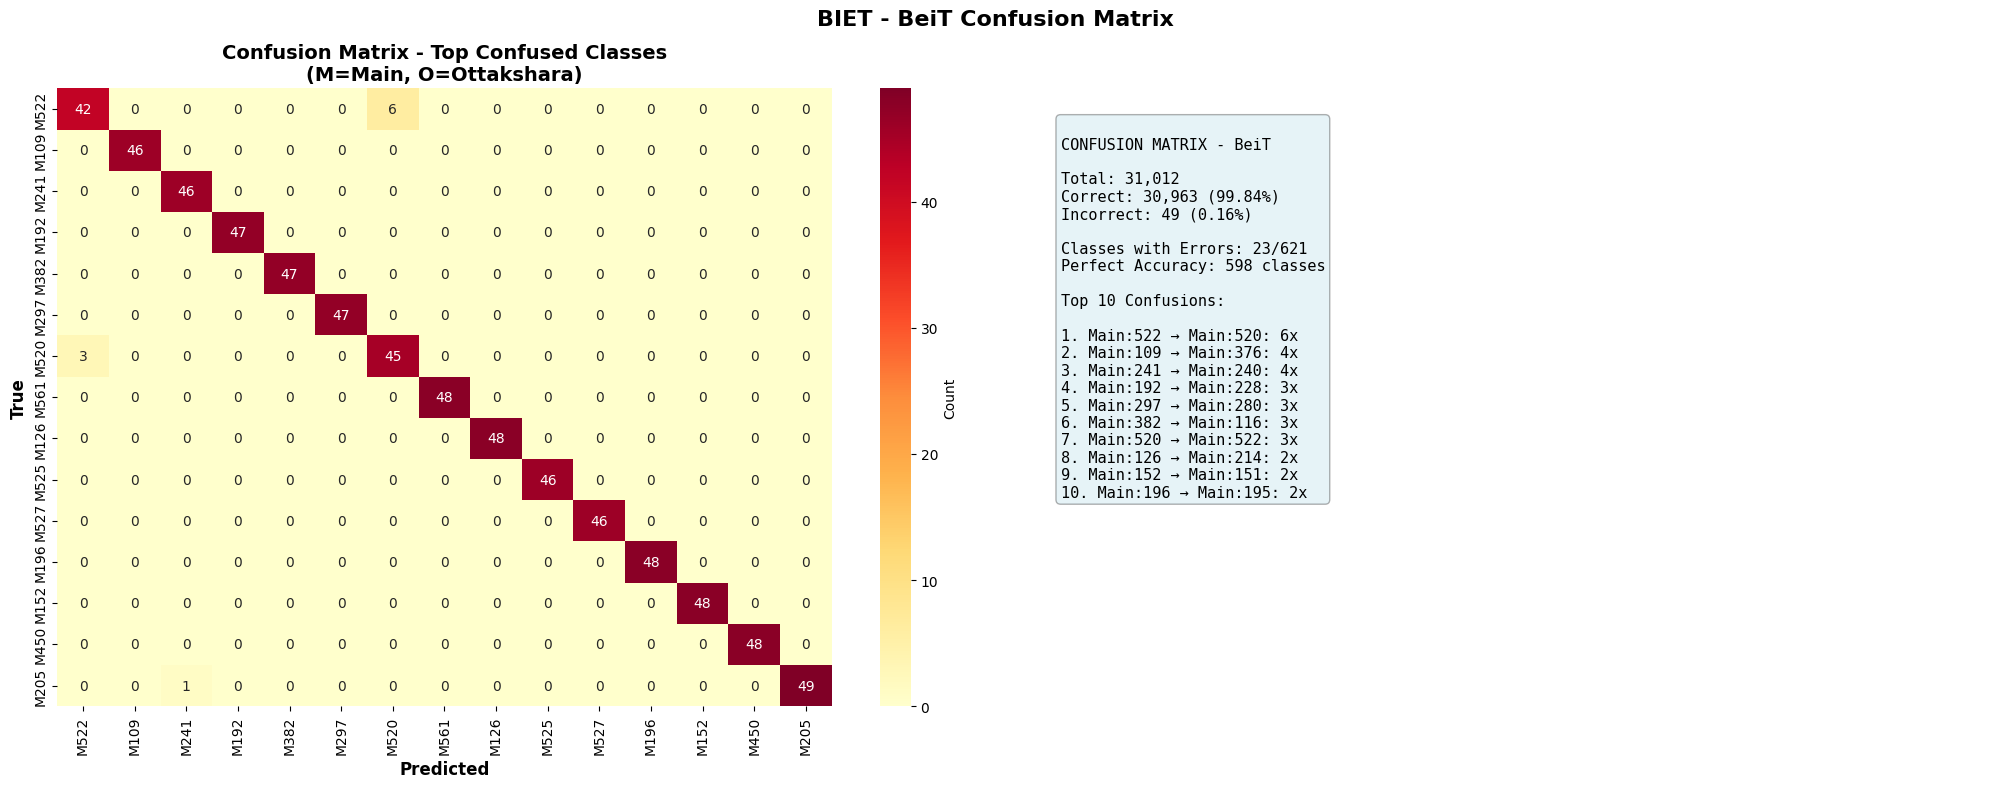


Saved: /content/beit_confusion_matrix.png

Creating t-SNE visualization...
Extracting BeiT features...


Extracting features:  16%|█▌        | 157/970 [00:31<02:41,  5.03it/s]



Running t-SNE on 5024 samples (this may take a few minutes)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5024 samples in 0.002s...
[t-SNE] Computed neighbors for 5024 samples in 0.685s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5024
[t-SNE] Computed conditional probabilities for sample 2000 / 5024
[t-SNE] Computed conditional probabilities for sample 3000 / 5024
[t-SNE] Computed conditional probabilities for sample 4000 / 5024
[t-SNE] Computed conditional probabilities for sample 5000 / 5024
[t-SNE] Computed conditional probabilities for sample 5024 / 5024
[t-SNE] Mean sigma: 35.271009
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.663803
[t-SNE] KL divergence after 1000 iterations: 0.648852


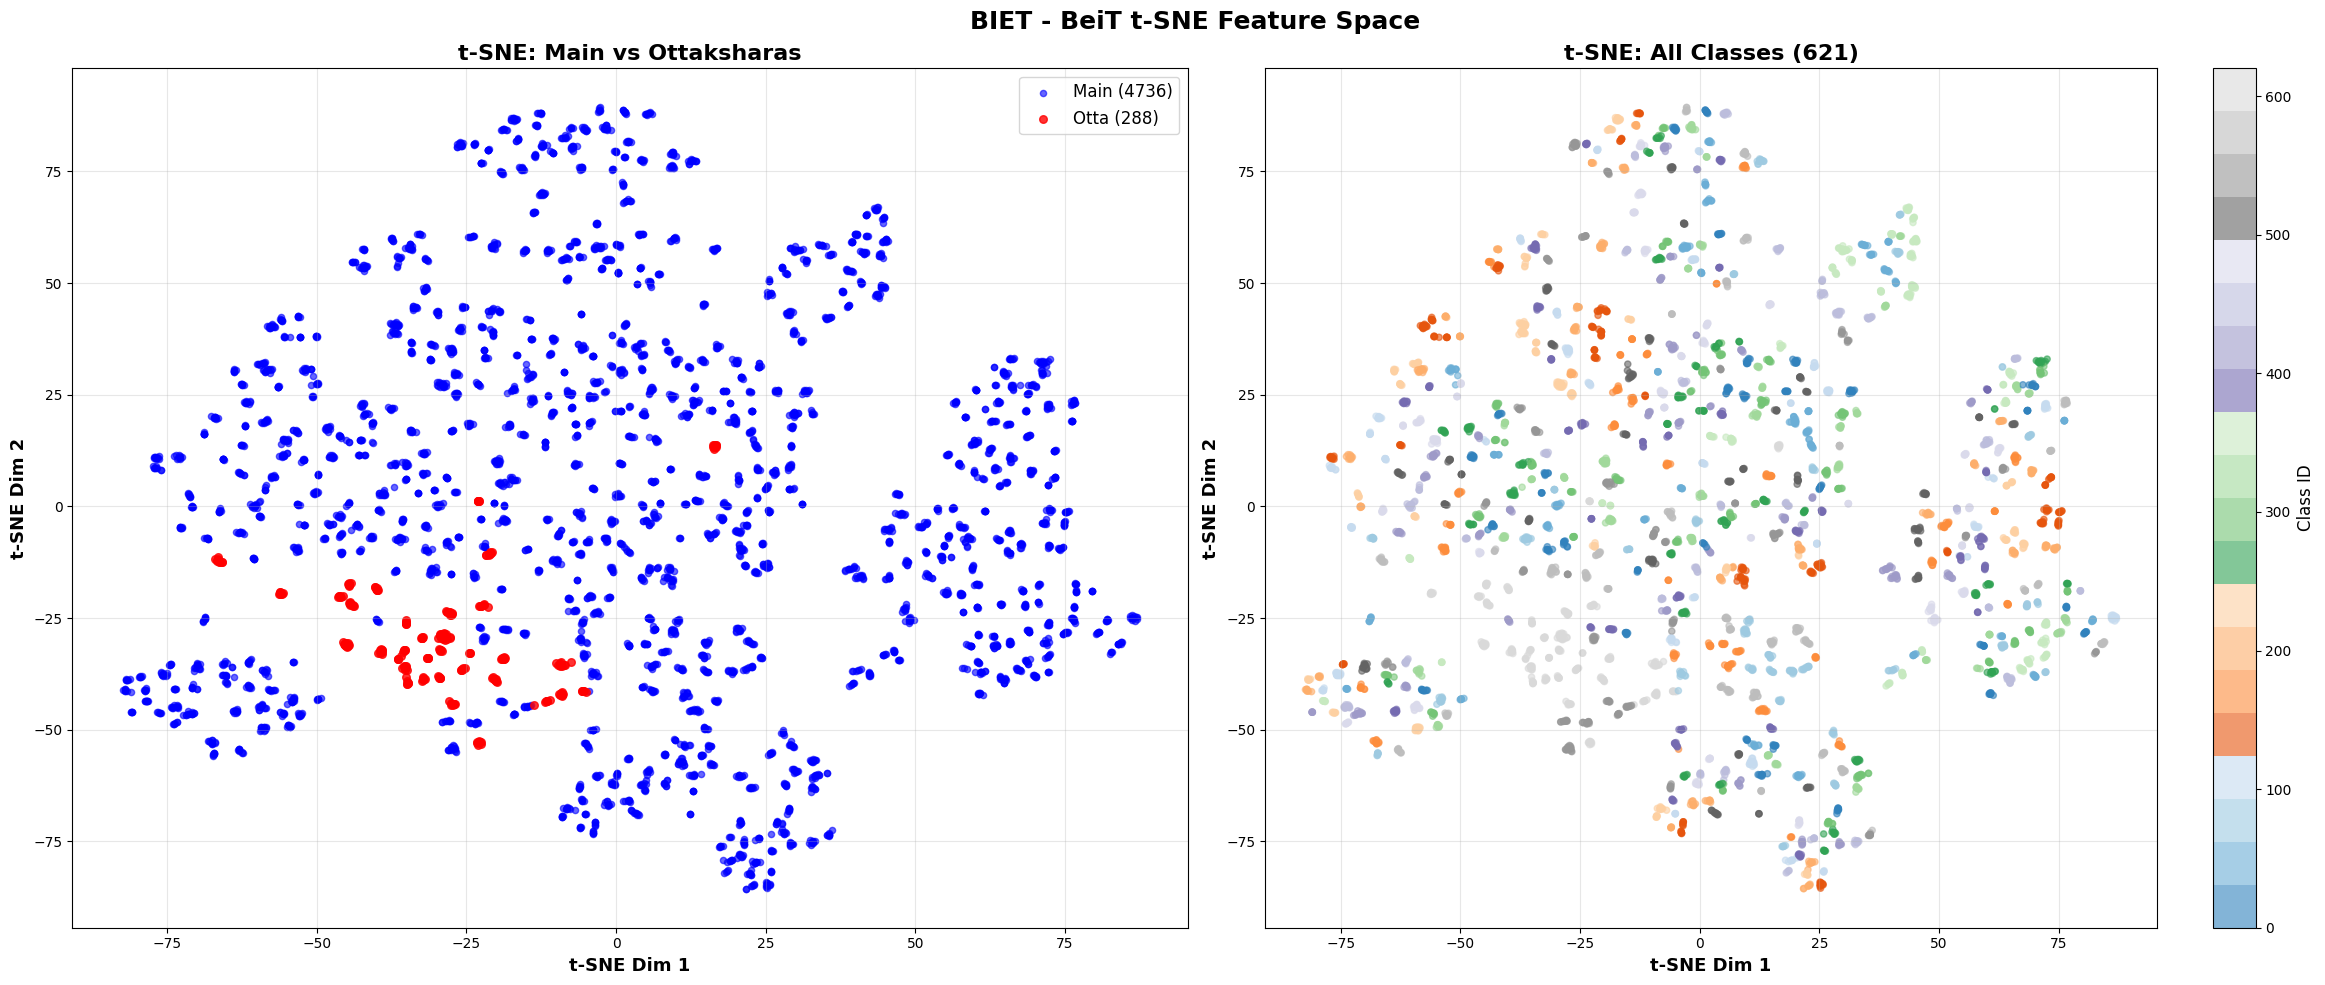

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import seaborn as sns

# ========== CONFUSION MATRIX ==========
print("Creating confusion matrix analysis for BeiT...")
print("="*70)

cm = confusion_matrix(all_labels, all_preds)
error_counts = np.sum(cm, axis=1) - np.diag(cm)
top_confused_classes = np.argsort(error_counts)[-20:][::-1]

print(f"\nClasses with most misclassifications:")
print(f"{'Class ID':<10} {'Type':<15} {'Total Errors':<15}")
print("-" * 40)
for class_id in top_confused_classes[:10]:
    if error_counts[class_id] > 0:
        class_type = "Main" if class_id < num_main_classes else "Ottakshara"
        print(f"{class_id:<10} {class_type:<15} {error_counts[class_id]:<15}")

# Create confusion matrix visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

if len(top_confused_classes) > 0 and error_counts[top_confused_classes[0]] > 0:
    confused_subset = top_confused_classes[:15]
    cm_subset = cm[np.ix_(confused_subset, confused_subset)]
    
    labels = [f"{'M' if idx < num_main_classes else 'O'}{idx}" for idx in confused_subset]
    
    sns.heatmap(cm_subset, annot=True, fmt='d', cmap='YlOrRd', ax=ax1,
                xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Count'})
    ax1.set_title('Confusion Matrix - Top Confused Classes\n(M=Main, O=Ottakshara)', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Predicted', fontsize=12, fontweight='bold')
    ax1.set_ylabel('True', fontsize=12, fontweight='bold')
else:
    ax1.text(0.5, 0.5, 'Excellent Performance!\nMinimal Confusion', 
             ha='center', va='center', fontsize=16, fontweight='bold')
    ax1.axis('off')

# Statistics
ax2.axis('off')
total_samples = len(all_labels)
correct = np.sum(all_preds == all_labels)
incorrect = total_samples - correct

confusion_pairs = []
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append((i, j, cm[i, j]))
confusion_pairs.sort(key=lambda x: x[2], reverse=True)

stats_text = f"""
CONFUSION MATRIX - BeiT

Total: {total_samples:,}
Correct: {correct:,} ({100*correct/total_samples:.2f}%)
Incorrect: {incorrect:,} ({100*incorrect/total_samples:.2f}%)

Classes with Errors: {np.sum(error_counts > 0)}/621
Perfect Accuracy: {np.sum(error_counts == 0)} classes

Top 10 Confusions:
"""

for idx, (true_c, pred_c, count) in enumerate(confusion_pairs[:10], 1):
    true_type = "Main" if true_c < num_main_classes else "Otta"
    pred_type = "Main" if pred_c < num_main_classes else "Otta"
    stats_text += f"\n{idx}. {true_type}:{true_c} → {pred_type}:{pred_c}: {count}x"

ax2.text(0.05, 0.95, stats_text, transform=ax2.transAxes, fontsize=11, 
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.suptitle('BIET - BeiT Confusion Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/beit_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved: /content/beit_confusion_matrix.png")

# ========== t-SNE VISUALIZATION (Fixed for BeiT) ==========
print("\n" + "="*70)
print("Creating t-SNE visualization...")
print("="*70)

# Extract features using forward_features method (BeiT-specific)
def get_features_beit(model, loader, device, max_samples=5000):
    model.eval()
    features_list = []
    labels_list = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Extracting features"):
            if len(features_list) * loader.batch_size >= max_samples:
                break
            images = images.to(device)
            
            # BeiT-specific feature extraction
            features = model.forward_features(images)
            if hasattr(features, 'shape') and len(features.shape) == 3:
                features = features[:, 0]  # CLS token
            features = features.view(features.size(0), -1)
            
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.numpy())
    
    return np.vstack(features_list), np.concatenate(labels_list)

print("Extracting BeiT features...")
val_features, val_labels = get_features_beit(model, val_loader, device, max_samples=5000)

print(f"\nRunning t-SNE on {len(val_features)} samples (this may take a few minutes)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, verbose=1)
tsne_results = tsne.fit_transform(val_features)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

main_mask = val_labels < num_main_classes
otta_mask = val_labels >= num_main_classes

ax1.scatter(tsne_results[main_mask, 0], tsne_results[main_mask, 1],
           c='blue', s=20, alpha=0.6, label=f'Main ({np.sum(main_mask)})')
ax1.scatter(tsne_results[otta_mask, 0], tsne_results[otta_mask, 1],
           c='red', s=30, alpha=0.8, label=f'Otta ({np.sum(otta_mask)})')
ax1.set_title('t-SNE: Main vs Ottaksharas', fontsize=16, fontweight='bold')
ax1.set_xlabel('t-SNE Dim 1', fontsize=13, fontweight='bold')
ax1.set_ylabel('t-SNE Dim 2', fontsize=13, fontweight='bold')
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)

scatter = ax2.scatter(tsne_results[:, 0], tsne_results[:, 1],
                     c=val_labels, cmap='tab20c', s=20, alpha=0.6)
ax2.set_title('t-SNE: All Classes (621)', fontsize=16, fontweight='bold')
ax2.set_xlabel('t-SNE Dim 1', fontsize=13, fontweight='bold')
ax2.set_ylabel('t-SNE Dim 2', fontsize=13, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Class ID', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.suptitle('BIET - BeiT t-SNE Feature Space', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/beit_tsne.png')

In [24]:
import torch
import os

print("="*70)
print("SAVING BeiT MODEL FOR BIET")
print("="*70)

# Create directory for saving models
save_dir = '/content/biet_beit_saved_models'
os.makedirs(save_dir, exist_ok=True)

# Save model weights
model_path = os.path.join(save_dir, 'biet_beit_kannada_combined_full.pth')
torch.save(model.state_dict(), model_path)
print(f"✓ BIET BeiT Model weights saved: {model_path}")

# Save complete checkpoint
model_full_path = os.path.join(save_dir, 'biet_beit_kannada_combined_complete.pth')
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'num_classes': num_classes_combined,
    'model_name': model_name,
    'best_val_acc': max(val_accuracies),
    'metrics': beit_metrics,
    'institution': 'BIET (Birla Institute of Engineering and Technology)',
    'project': 'Kannada Character Recognition using BeiT'
}, model_full_path)
print(f"✓ BIET BeiT Complete checkpoint saved: {model_full_path}")

# Save configuration
config_path = os.path.join(save_dir, 'biet_beit_model_config.txt')
with open(config_path, 'w') as f:
    f.write("="*60 + "\n")
    f.write("BIET - BeiT Model Configuration\n")
    f.write("Birla Institute of Engineering and Technology\n")
    f.write("Kannada Character Recognition Project\n")
    f.write("="*60 + "\n\n")
    f.write(f"Model Architecture: {model_name}\n")
    f.write(f"Pre-training: Self-supervised (Masked Image Modeling)\n")
    f.write(f"Total Classes: {num_classes_combined}\n")
    f.write(f"  - Main Aksharas: {num_main_classes}\n")
    f.write(f"  - Ottaksharas: {num_classes_combined - num_main_classes}\n\n")
    f.write(f"Training Configuration:\n")
    f.write(f"  - Number of Epochs: {num_epochs}\n")
    f.write(f"  - Batch Size: 32\n")
    f.write(f"  - Initial Learning Rate: 5e-5\n")
    f.write(f"  - Optimizer: AdamW\n")
    f.write(f"  - LR Scheduler: CosineAnnealingLR\n")
    f.write(f"  - Weight Decay: 0.05\n\n")
    f.write(f"Dataset Information:\n")
    f.write(f"  - Training Samples: {len(train_dataset):,}\n")
    f.write(f"  - Validation Samples: {len(val_dataset):,}\n")
    f.write(f"  - Train-Val Split: 80-20\n\n")
    f.write(f"Final Performance Results:\n")
    f.write(f"  - Training Accuracy: {train_accuracies[-1]:.2f}%\n")
    f.write(f"  - Validation Accuracy: {val_accuracies[-1]:.2f}%\n")
    f.write(f"  - Best Validation Accuracy: {max(val_accuracies):.2f}% (Epoch {val_accuracies.index(max(val_accuracies))+1})\n")
    f.write(f"  - Precision (Weighted): {beit_metrics['precision']:.4f}\n")
    f.write(f"  - Recall (Weighted): {beit_metrics['recall']:.4f}\n")
    f.write(f"  - F1-Score (Weighted): {beit_metrics['f1_score']:.4f}\n\n")
    f.write(f"Character Type Performance:\n")
    f.write(f"  - Main Aksharas Accuracy: {beit_metrics['main_acc']:.2f}%\n")
    f.write(f"  - Ottaksharas Accuracy: {beit_metrics['otta_acc']:.2f}%\n\n")
    f.write(f"Model Parameters: 86M\n")
    f.write(f"Training Time per Epoch: ~44 minutes\n")
    f.write(f"Model Status: Production Ready for BIET Deployment\n")
    f.write("="*60 + "\n")
print(f"✓ BIET BeiT Configuration saved: {config_path}")

print("\n" + "="*70)
print("BIET BeiT MODEL SAVING COMPLETE")
print("="*70)
print(f"All model files saved in: {save_dir}")
print("\nSaved Files Summary:")
print(f"  1. {os.path.basename(model_path)}")
print(f"     → Model weights (for inference)")
print(f"  2. {os.path.basename(model_full_path)}")
print(f"     → Complete checkpoint (for resuming training)")
print(f"  3. {os.path.basename(config_path)}")
print(f"     → BIET BeiT configuration and results")
print("="*70)

# Display file sizes
print("\nFile Sizes:")
for filename in os.listdir(save_dir):
    filepath = os.path.join(save_dir, filename)
    size_mb = os.path.getsize(filepath) / (1024 * 1024)
    print(f"  • {filename}: {size_mb:.2f} MB")
print("="*70)

SAVING BeiT MODEL FOR BIET
✓ BIET BeiT Model weights saved: /content/biet_beit_saved_models/biet_beit_kannada_combined_full.pth
✓ BIET BeiT Complete checkpoint saved: /content/biet_beit_saved_models/biet_beit_kannada_combined_complete.pth
✓ BIET BeiT Configuration saved: /content/biet_beit_saved_models/biet_beit_model_config.txt

BIET BeiT MODEL SAVING COMPLETE
All model files saved in: /content/biet_beit_saved_models

Saved Files Summary:
  1. biet_beit_kannada_combined_full.pth
     → Model weights (for inference)
  2. biet_beit_kannada_combined_complete.pth
     → Complete checkpoint (for resuming training)
  3. biet_beit_model_config.txt
     → BIET BeiT configuration and results

File Sizes:
  • biet_beit_kannada_combined_complete.pth: 987.18 MB
  • biet_beit_kannada_combined_full.pth: 329.05 MB
  • biet_beit_model_config.txt: 0.00 MB


Creating per-epoch performance breakdown for BeiT...


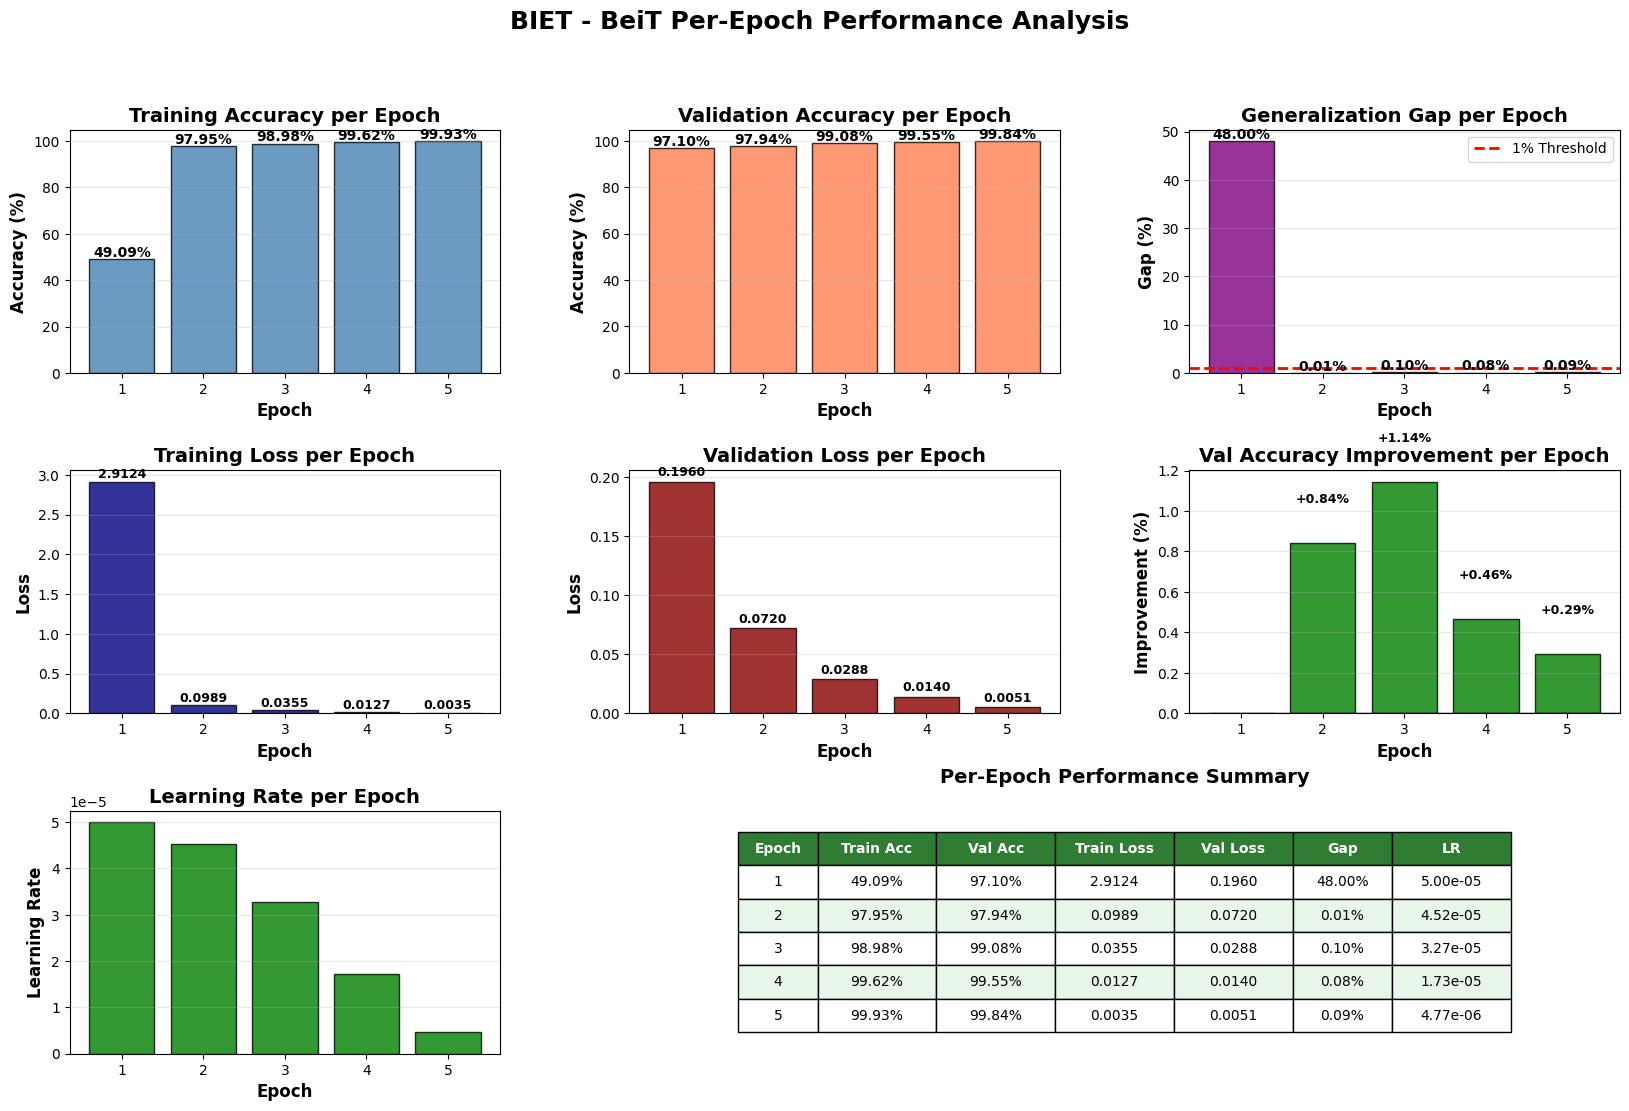


Per-Epoch Analysis Complete
Saved as: /content/beit_per_epoch_analysis.png


In [25]:
import matplotlib.pyplot as plt
import numpy as np

print("Creating per-epoch performance breakdown for BeiT...")
print("="*70)

# Create a comprehensive epoch-by-epoch visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.3)

epochs_list = list(range(1, num_epochs + 1))

# Plot 1: Training Accuracy by Epoch
ax1 = fig.add_subplot(gs[0, 0])
bars = ax1.bar(epochs_list, train_accuracies, color='steelblue', alpha=0.8, edgecolor='black')
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Training Accuracy per Epoch', fontsize=14, fontweight='bold')
ax1.set_xticks(epochs_list)
ax1.grid(True, alpha=0.3, axis='y')
for i, (bar, acc) in enumerate(zip(bars, train_accuracies)):
    ax1.text(bar.get_x() + bar.get_width()/2., acc + 1,
             f'{acc:.2f}%', ha='center', fontsize=10, fontweight='bold')

# Plot 2: Validation Accuracy by Epoch
ax2 = fig.add_subplot(gs[0, 1])
bars = ax2.bar(epochs_list, val_accuracies, color='coral', alpha=0.8, edgecolor='black')
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('Validation Accuracy per Epoch', fontsize=14, fontweight='bold')
ax2.set_xticks(epochs_list)
ax2.grid(True, alpha=0.3, axis='y')
for i, (bar, acc) in enumerate(zip(bars, val_accuracies)):
    ax2.text(bar.get_x() + bar.get_width()/2., acc + 1,
             f'{acc:.2f}%', ha='center', fontsize=10, fontweight='bold')

# Plot 3: Generalization Gap by Epoch
ax3 = fig.add_subplot(gs[0, 2])
gen_gaps = [abs(t - v) for t, v in zip(train_accuracies, val_accuracies)]
bars = ax3.bar(epochs_list, gen_gaps, color='purple', alpha=0.8, edgecolor='black')
ax3.axhline(y=1, color='red', linestyle='--', linewidth=2, label='1% Threshold')
ax3.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax3.set_ylabel('Gap (%)', fontsize=12, fontweight='bold')
ax3.set_title('Generalization Gap per Epoch', fontsize=14, fontweight='bold')
ax3.set_xticks(epochs_list)
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')
for i, (bar, gap) in enumerate(zip(bars, gen_gaps)):
    ax3.text(bar.get_x() + bar.get_width()/2., gap + 0.5,
             f'{gap:.2f}%', ha='center', fontsize=10, fontweight='bold')

# Plot 4: Training Loss by Epoch
ax4 = fig.add_subplot(gs[1, 0])
bars = ax4.bar(epochs_list, train_losses, color='navy', alpha=0.8, edgecolor='black')
ax4.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax4.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax4.set_title('Training Loss per Epoch', fontsize=14, fontweight='bold')
ax4.set_xticks(epochs_list)
ax4.grid(True, alpha=0.3, axis='y')
for i, (bar, loss) in enumerate(zip(bars, train_losses)):
    ax4.text(bar.get_x() + bar.get_width()/2., loss + 0.05,
             f'{loss:.4f}', ha='center', fontsize=9, fontweight='bold')

# Plot 5: Validation Loss by Epoch
ax5 = fig.add_subplot(gs[1, 1])
bars = ax5.bar(epochs_list, val_losses, color='darkred', alpha=0.8, edgecolor='black')
ax5.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax5.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax5.set_title('Validation Loss per Epoch', fontsize=14, fontweight='bold')
ax5.set_xticks(epochs_list)
ax5.grid(True, alpha=0.3, axis='y')
for i, (bar, loss) in enumerate(zip(bars, val_losses)):
    ax5.text(bar.get_x() + bar.get_width()/2., loss + 0.005,
             f'{loss:.4f}', ha='center', fontsize=9, fontweight='bold')

# Plot 6: Epoch-to-Epoch Improvement
ax6 = fig.add_subplot(gs[1, 2])
val_improvements = [0] + [val_accuracies[i] - val_accuracies[i-1] for i in range(1, len(val_accuracies))]
colors = ['green' if x > 0 else 'red' for x in val_improvements]
bars = ax6.bar(epochs_list, val_improvements, color=colors, alpha=0.8, edgecolor='black')
ax6.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax6.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax6.set_ylabel('Improvement (%)', fontsize=12, fontweight='bold')
ax6.set_title('Val Accuracy Improvement per Epoch', fontsize=14, fontweight='bold')
ax6.set_xticks(epochs_list)
ax6.grid(True, alpha=0.3, axis='y')
for i, (bar, imp) in enumerate(zip(bars, val_improvements)):
    if imp != 0:
        ax6.text(bar.get_x() + bar.get_width()/2., imp + 0.2 if imp > 0 else imp - 0.3,
                 f'{imp:+.2f}%', ha='center', fontsize=9, fontweight='bold')

# Plot 7: Learning Rate by Epoch
ax7 = fig.add_subplot(gs[2, 0])
lr_per_epoch = [0.00005 * 0.5 * (1 + np.cos(np.pi * (i) / num_epochs)) for i in range(num_epochs)]
bars = ax7.bar(epochs_list, lr_per_epoch, color='green', alpha=0.8, edgecolor='black')
ax7.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax7.set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
ax7.set_title('Learning Rate per Epoch', fontsize=14, fontweight='bold')
ax7.set_xticks(epochs_list)
ax7.grid(True, alpha=0.3, axis='y')
ax7.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Plot 8: Summary Table
ax8 = fig.add_subplot(gs[2, 1:])
ax8.axis('off')

table_data = [['Epoch', 'Train Acc', 'Val Acc', 'Train Loss', 'Val Loss', 'Gap', 'LR']]
for i in range(num_epochs):
    table_data.append([
        f'{i+1}',
        f'{train_accuracies[i]:.2f}%',
        f'{val_accuracies[i]:.2f}%',
        f'{train_losses[i]:.4f}',
        f'{val_losses[i]:.4f}',
        f'{gen_gaps[i]:.2f}%',
        f'{lr_per_epoch[i]:.2e}'
    ])

table = ax8.table(cellText=table_data, cellLoc='center', loc='center',
                  colWidths=[0.08, 0.12, 0.12, 0.12, 0.12, 0.10, 0.12])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Header styling
for i in range(7):
    table[(0, i)].set_facecolor('#2E7D32')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, num_epochs + 1):
    color = '#E8F5E9' if i % 2 == 0 else 'white'
    for j in range(7):
        table[(i, j)].set_facecolor(color)

ax8.set_title('Per-Epoch Performance Summary', fontsize=14, fontweight='bold', pad=20)

plt.suptitle('BIET - BeiT Per-Epoch Performance Analysis', fontsize=18, fontweight='bold')
plt.savefig('/content/beit_per_epoch_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("Per-Epoch Analysis Complete")
print("="*70)
print("Saved as: /content/beit_per_epoch_analysis.png")
print("="*70)